# Unsupervised Deep Learning Tutorial 1.1

In this part of the tutorial we will look at Long Short-Term Memory (LSTM) networks and how they work with time series.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
torch.manual_seed(0)

from typing import Tuple, Optional

Recurrent neural networks typically require a lot of data and time to train since temporal relationships are difficult to learn. Therefore, today we will train our models on extremely simple toy time series. The following function can be used to generate such datasets (feel free to change the parameters or try different time series):

In [2]:
def generate_toy_time_series(sequence_length: int = 100, delta_time: float = .01) -> Tuple[torch.Tensor, torch.Tensor]:

    # Generate a single sine wave
    sequence = torch.linspace(0, delta_time*sequence_length, sequence_length).sin()
    
    # Reshape to (batch_size, sequence_length, input_size)
    # Here the input size is the number of features of our time series, which is 1, i.e. sin(t)
    # Your models should work independently of these 3 values
    sequence = sequence.reshape(1, -1, 1)
    
    # Observations
    X = sequence[:, :-1]
    
    # Labels (observations shifted by one)
    y = sequence[:, 1:]
    
    return X, y

torch.Size([1, 99, 1]) torch.Size([1, 99, 1])


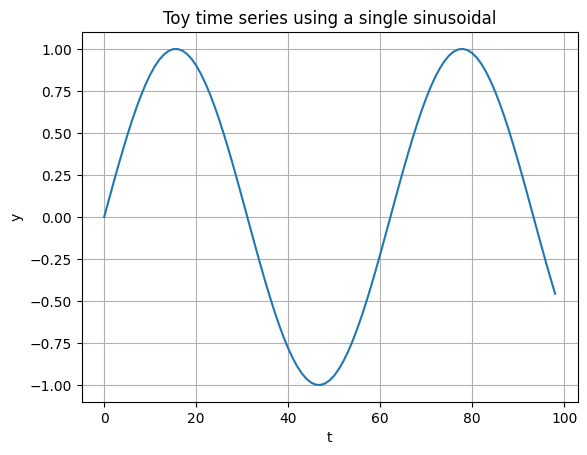

In [3]:
X, y = generate_toy_time_series(sequence_length=100, delta_time=.1)
print(X.shape, y.shape)
plt.plot(X.squeeze())
plt.xlabel('t')
plt.ylabel('y')
plt.title('Toy time series using a single sinusoidal')
plt.grid()
plt.show()

The model will attempt to learn the time series presented above. It will be trained in an autoregressive self-supervised fashion, where the input is the function at time $t$ and the output is the estimated value of the function at time $t+1$. To be able to learn temporal information, the LSTM makes use of the hidden state $h_t$ and the cell state $c_t$ as presented in the lecture.

Formally, the forward pass of the LSTM is defined as follows:

\begin{align}
\tag{1a} & i_t = \sigma(x_tW^{(x,i)} + h_{t-1}W^{(h,i)} + b_i) \\
    \tag{1b} & f_t = \sigma(x_tW^{(x,f)} + h_{t-1}W^{(h,f)} + b_f) \\
\tag{1c} & o_t = \sigma(x_tW^{(x,o)} + h_{t-1}W^{(h,o)} + b_o) \\
\tag{2} & c_t = \tanh(x_tW^{(x,c)} + h_{t-1}W^{(h,c)} + b_c) \\
\tag{3} & c_t \gets f_t\odot c_{t-1} + i_t \odot c_t \\
\tag{4} & h_t = o_t \odot \tanh(c_t)
\end{align}

The input is the feature vector at time $t$, namely $x_t\in\mathbb{R}^n$ and the output is the hidden state at time $t$, namely $h_t\in\mathbb{R}^m$. The input, forget, and output gates are represented as $i$, $f$, and $o$ respectively, and are characterized by $n\times m$ matrices $W^{x}$, $m\times m$ matrices $W^{h}$, and biases $b\in\mathbb{R}^m$. Here $\sigma$ is the sigmoid function and $\odot$ is the Hadamard product (pairwise multiplication of 2 vectors).

The implementation using PyTorch is quite straightforward. We can define each matrix and bias as a single linear layer

In [4]:
class CustomLSTMCell(nn.Module):
    def __init__(self, input_size: int = 10, hidden_size: int = 50) -> None:
        super().__init__()
        
        self.input_size = input_size # n
        self.hidden_size = hidden_size # m
        
        # Input gate
        self.Wxi = nn.Linear(input_size, hidden_size)
        self.Whi = nn.Linear(hidden_size, hidden_size)

        # Forget gate
        self.Wxf = nn.Linear(input_size, hidden_size)
        self.Whf = nn.Linear(hidden_size, hidden_size)

        # Output gate
        self.Wxo = nn.Linear(input_size, hidden_size)
        self.Who = nn.Linear(hidden_size, hidden_size)

        # Memory proposal
        self.Wxc = nn.Linear(input_size, hidden_size)
        self.Whc = nn.Linear(hidden_size, hidden_size)
        
        # Final output
        self.Wo = nn.Linear(hidden_size, input_size)

    def single_pass(self, x: torch.Tensor, h: Optional[torch.Tensor] = None, c: Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, torch.Tensor]:
        
        # Happens in the first forward pass. Set h and c to 0
        if h is None: h = torch.zeros(len(x), self.hidden_size)
        if c is None: c = torch.zeros(len(x), self.hidden_size)

        # Gates
        i = F.sigmoid(self.Wxi(x) + self.Whi(h))
        f = F.sigmoid(self.Wxf(x) + self.Whf(h))
        o = F.sigmoid(self.Wxo(x) + self.Who(h))

        # Update h and c
        c_new = F.tanh(self.Wxc(x) + self.Whc(h))
        c_new = f * c + i * c_new
        h_new = o * F.tanh(c_new)
        
        return h_new, c_new
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        assert x.ndim == 3
        batch_size, sequence_length, input_size = x.shape
        h, c = None, None
        
        # Store all intermediate outputs
        outputs = []

        # Loop over the whole sequence.
        # Use the hidden states from the previous iteration
        for t in range(sequence_length):
            h, c = self.single_pass(x[:, t], h, c)
            outputs.append(self.Wo(h))
            
        return torch.stack(outputs, dim=1)


In [5]:
model = CustomLSTMCell(input_size=1, hidden_size=5)
print(model)
print(f'Number of parameters: {sum(p.numel() for p in model.parameters())}')

CustomLSTMCell(
  (Wxi): Linear(in_features=1, out_features=5, bias=True)
  (Whi): Linear(in_features=5, out_features=5, bias=True)
  (Wxf): Linear(in_features=1, out_features=5, bias=True)
  (Whf): Linear(in_features=5, out_features=5, bias=True)
  (Wxo): Linear(in_features=1, out_features=5, bias=True)
  (Who): Linear(in_features=5, out_features=5, bias=True)
  (Wxc): Linear(in_features=1, out_features=5, bias=True)
  (Whc): Linear(in_features=5, out_features=5, bias=True)
  (Wo): Linear(in_features=5, out_features=1, bias=True)
)
Number of parameters: 166


Amazing! Let's give it a shot:

In [6]:
test_output = model(X)
test_output.shape

torch.Size([1, 99, 1])

Everything appears to be working. Notice that the output of the LSTM is of the same shape as the input. This allows for stacking multiple LSTMs on top of eachother! Now for the training, we will use the Mean Squared Error loss to compare the predicted time series and the ground truth. Also, we will use the Adam optimizer. The task is really simple so the hyperparameters probably don't matter too much.

In [7]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

We are ready to train! This might take a while..

In [8]:
for i in range(1001):
    preds = model(X)
    loss = loss_fn(y, preds)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i%100 == 0: print(f'Epoch: {i} | Loss: {loss.item():.4f}')

Epoch: 0 | Loss: 0.4986
Epoch: 100 | Loss: 0.2924
Epoch: 200 | Loss: 0.0867
Epoch: 300 | Loss: 0.0315
Epoch: 400 | Loss: 0.0144
Epoch: 500 | Loss: 0.0059
Epoch: 600 | Loss: 0.0021
Epoch: 700 | Loss: 0.0009
Epoch: 800 | Loss: 0.0006
Epoch: 900 | Loss: 0.0005
Epoch: 1000 | Loss: 0.0004


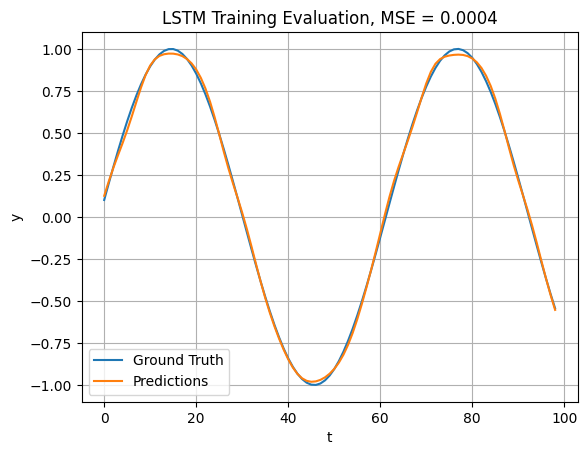

In [9]:
plt.plot(y.squeeze(), label='Ground Truth')
with torch.inference_mode():
    predictions = model(X)
plt.plot(predictions.squeeze(), label='Predictions')
plt.legend()
plt.xlabel('t')
plt.ylabel('y')
plt.title(f'LSTM Training Evaluation, MSE = {loss:.4f}')
plt.grid()
plt.show()

Wow! Our model is very good. Keep in mind that is a really simple solved with a really simple model. After all, we have only a single feature. It still impressive that our model considers the last 100 timesteps before making a decision. That is like remembering what you ate for dinner the last 100 days in order to determine what to eat today. Long-term memory indeed.